# Notebook 13: Using Deep Learning to Study SUSY with Pytorch

## Learning Goals
The goal of this notebook is to introduce the powerful PyTorch framework for building neural networks and use it to analyze the SUSY dataset. After this notebook, the reader should understand the mechanics of PyTorch and how to construct DNNs using this package. In addition, the reader is encouraged to explore the GPU backend available in Pytorch on this dataset.

## Overview
In this notebook, we use Deep Neural Networks to classify the supersymmetry dataset, first introduced by Baldi et al. in [Nature Communication (2015)](https://www.nature.com/articles/ncomms5308). The SUSY data set consists of 5,000,000 Monte-Carlo samples of supersymmetric and non-supersymmetric collisions with $18$ features. The signal process is the production of electrically-charged supersymmetric particles which decay to $W$ bosons and an electrically-neutral supersymmetric particle that is invisible to the detector.

The first $8$ features are "raw" kinematic features that can be directly measured from collisions. The final $10$ features are "hand constructed" features that have been chosen using physical knowledge and are known to be important in distinguishing supersymmetric and non-supersymmetric collision events. More specifically, they are given by the column names below.

In this notebook, we study this dataset using Pytorch.

In [1]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs

## Structure of the Procedure

Constructing a Deep Neural Network to solve ML problems is a multiple-stage process. Quite generally, one can identify the key steps as follows:

* ***step 1:*** Load and process the data
* ***step 2:*** Define the model and its architecture
* ***step 3:*** Choose the optimizer and the cost function
* ***step 4:*** Train the model 
* ***step 5:*** Evaluate the model performance on the *unseen* test data
* ***step 6:*** Modify the hyperparameters to optimize performance for the specific data set

Below, we sometimes combine some of these steps together for convenience.

Notice that we take a rather different approach, compared to the simpler MNIST Keras notebook. We first define a set of classes and functions and run the actual computation only in the very end.

### Step 1: Load and Process the SUSY Dataset

The supersymmetry dataset can be downloaded from the UCI Machine Learning repository on [https://archive.ics.uci.edu/ml/datasets/SUSY](https://archive.ics.uci.edu/ml/datasets/SUSY). The dataset is quite large. Download the dataset and unzip it in a directory.

Loading data in Pytroch is done by creating a user-defined a class, which we name `SUSY_Dataset`, and is a child of the `torch.utils.data.Dataset` class. This ensures that all necessary attributes required for the processing of the data during the training and test stages are easily inherited. The `__init__` method of our custom data class should contain the usual code for loading the data, which is problem-specific, and has been discussed for the SUSY data set in Notebook 5. More importantly, the user-defined data class must override the `__len__` and `__getitem__` methods of the parent `DataSet` class. The former returns the size of the data set, while the latter allows the user to access a particular data point from the set by specifying its index.

In [2]:
from torchvision import datasets # load data

class SUSY_Dataset(torch.utils.data.Dataset):
    """SUSY pytorch dataset."""

    def __init__(self, data_file, root_dir, dataset_size, train=True, transform=None, high_level_feats=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            train (bool, optional): If set to `True` load training data.
            transform (callable, optional): Optional transform to be applied on a sample.
            high_level_festures (bool, optional): If set to `True`, working with high-level features only. 
                                        If set to `False`, working with low-level features only.
                                        Default is `None`: working with all features
        """

        import pandas as pd

        features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 
                'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

        low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi']

        high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


        #Number of datapoints to work with
        df = pd.read_csv(root_dir+data_file, header=None,nrows=dataset_size,engine='python')
        df.columns=features
        Y = df['SUSY']
        X = df[[col for col in df.columns if col!="SUSY"]]

        # set training and test data size
        train_size=int(0.8*dataset_size)
        self.train=train

        if self.train:
            X=X[:train_size]
            Y=Y[:train_size]
            print("Training on {} examples".format(train_size))
        else:
            X=X[train_size:]
            Y=Y[train_size:]
            print("Testing on {} examples".format(dataset_size-train_size))


        self.root_dir = root_dir
        self.transform = transform

        # make datasets using only the 8 low-level features and 10 high-level features
        if high_level_feats is None:
            self.data=(X.as_matrix().astype(np.float32),Y.as_matrix().astype(int))
            print("Using both high and low level features")
        elif high_level_feats is True:
            self.data=(X[high_features].as_matrix().astype(np.float32),Y.as_matrix().astype(int))
            print("Using both high-level features only.")
        elif high_level_feats is False:
            self.data=(X[low_features].as_matrix().astype(np.float32),Y.as_matrix().astype(int))
            print("Using both low-level features only.")


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])

        if self.transform:
            sample=self.transform(sample)

        return sample

Last, we define a helper function `load_data()` that accepts as a required argument the set of parameters `args`, and returns two generators: `test_loader` and `train_loader` which readily return mini-batches.

In [3]:
def load_data(args):

    data_file='SUSY.csv'
    root_dir=os.path.expanduser('~')+'/ML_review/SUSY_data/'

    kwargs = {} # CUDA arguments, if enabled
    # load and noralise train and test data
    train_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=True,high_level_feats=args.high_level_feats),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=False,high_level_feats=args.high_level_feats),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader

### Step 2: Define the Neural Net and its Architecture

To construct neural networks with Pytorch, we make another class called `model` as a child of Pytorch's `nn.Module` class. The `model` class initializes the types of layers needed for the deep neural net in its `__init__` method, while the DNN is assembled in a function method called `forward`, which accepts an `autograd.Variable` object and returns the output layer. Using this convention Pytorch will automatically recognize the structure of the DNN, and the `autograd` module will pull the gradients forward and backward using backprop.

Our code below is constructed in such a way that one can choose whether to use the high-level and low-level features separately and altogether. This choice determines the size of the fully-connected input layer `fc1`. Therefore the `__init__` method accepts the optional argument `high_level_feats`. 

In [4]:
from torch.autograd import Variable # differentiation of pytorch tensors
import torch.nn as nn # construct NN

class model(nn.Module):
    def __init__(self,high_level_feats=None):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()

        # an affine operation: y = Wx + b
        if high_level_feats is None:
            self.fc1 = nn.Linear(18, 200) # all features
        elif high_level_feats:
            self.fc1 = nn.Linear(10, 200) # low-level only
        else:
            self.fc1 = nn.Linear(8, 200) # high-level only


        self.batchnorm1=nn.BatchNorm1d(200, eps=1e-05, momentum=0.1)
        self.batchnorm2=nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)

        self.fc2 = nn.Linear(200, 100) # see forward function for dimensions
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        '''Defines the feed-forward function for the NN.

        A backward function is automatically defined using `torch.autograd`

        Parameters
        ----------
        x : autograd.Variable
            input data

        Returns
        -------
        autograd.Variable
            output layer of NN

        '''

        # apply rectified linear unit
        x = F.relu(self.fc1(x))
        # apply dropout
        #x=self.batchnorm1(x)
        x = F.dropout(x, training=self.training)


        # apply rectified linear unit
        x = F.relu(self.fc2(x))
        # apply dropout
        #x=self.batchnorm2(x)
        x = F.dropout(x, training=self.training)


        # apply affine operation fc2
        x = self.fc3(x)
        # soft-max layer
        x = F.log_softmax(x,dim=1)

        return x

### Steps 3+4+5: Choose the Optimizer and the Cost Function. Train and Evaluate the Model

Next, we define the function `evaluate_model`. The first argument, `args`, contains all hyperparameters needed for the DNN (see below). The second and third arguments are the `train_loader` and the `test_loader` objects, returned by the function `load_data()` we defined in Step 1 above. The `evaluate_model` function returns the final `test_loss` and `test_accuracy` of the model.

First, we initialize a `model` and call the object `DNN`. In order to define the loss function and the optimizer, we use modules `torch.nn.functional` (imported here as `F`) and `torch.optim`. As a loss function we choose the negative log-likelihood, and stored is under the variable `criterion`. As usual, we can choose any from a variety of different SGD-based optimizers, but we focus on the traditional SGD.

Next, we define two functions: `train()` and `test()`. They are called at the end of `evaluate_model` where we loop over the training epochs to train and test our model. 

The `train` function accepts an integer called `epoch`, which is only used to print the training data. We first set the `DNN` in a train mode using the `train()` method inherited from `nn.Module`. Then we loop over the mini-batches in `train_loader`. We cast the data as pytorch `Variable`, re-set the `optimizer`, perform the forward step by calling the `DNN` model on the `data` and computing the `loss`. The backprop algorithm is then easily done using the `backward()` method of the loss function `criterion`. We use `optimizer.step` to update the weights of the `DNN`. Last print the performance for every minibatch. `train` returns the loss on the data.

The `test` function is similar to `train` but its purpose is to test the performance of a trained model. Once we set the `DNN` model in `eval()` mode, the following steps are similar to those in `train`. We then compute the `test_loss` and the number of `correct` predictions, print the results and return them.  

In [5]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

def evaluate_model(args,train_loader,test_loader):

    # create model
    DNN = model(high_level_feats=args.high_level_feats)
    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(DNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))


    ################################################

    def train(epoch):
        '''Trains a NN using minibatches.

        Parameters
        ----------
        epoch : int
            Training epoch number.

        '''

        # set model to training mode (affects Dropout and BatchNorm)
        DNN.train()
        # loop over training data
        for batch_idx, (data, label) in enumerate(train_loader):
            # wrap minibatch data in Variable
            data, label = Variable(data), Variable(label)
            # zero gradient buffers
            optimizer.zero_grad()
            # compute output of final layer: forward step
            output = DNN(data)
            # compute loss
            loss = criterion(output, label)
            # run backprop: backward step
            loss.backward()
            # update weigths of NN
            optimizer.step()
            
            # print loss at current epoch
            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0]))
            

        return loss.data[0]

    ################################################

    def test():
        '''Tests NN performance.

        '''

        # evaluate model
        DNN.eval()

        test_loss = 0 # loss function on test data
        correct = 0 # number of correct predictions
        # loop over test data
        for data, label in test_loader:
            # wrap test data in Variable
            data, label = Variable(data, volatile=True), Variable(label)
            # compute model prediction softmax probability
            output = DNN(data)
            # compute test loss
            test_loss += criterion(output, label, size_average=False).data[0] # sum up batch loss
            # find most likely prediction
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            # update number of correct predictions
            correct += pred.eq(label.data.view_as(pred)).cpu().sum()

        # print test loss
        test_loss /= len(test_loader.dataset)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        

        return test_loss, correct / len(test_loader.dataset)


    ################################################


    train_loss=np.zeros((args.epochs,))
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)

    epochs=range(1, args.epochs + 1)
    for epoch in epochs:

        train_loss[epoch-1] = train(epoch)
        test_loss[epoch-1], test_accuracy[epoch-1] = test()



    return test_loss[-1], test_accuracy[-1]

### Step 6: Modify the Hyperparameters to Optimize Performance of the Model

To study the performance of the model for a variety of different `data_set_sizes` and `learning_rates`, we do a grid search. 

Let us define a function `grid_search`, which accepts the `args` variable containing all hyper-parameters needed for the problem. After choosing logarithmically-spaced `data_set_sizes` and `learning_rates`, we first loop over all `data_set_sizes`, update the `args` variable, and call the `load_data` function. We then loop once again over all `learning_rates`, update `args` and call `evaluate_model`.

In [6]:
def grid_search(args):


    # perform grid search over learnign rate and number of hidden neurons
    dataset_sizes=[1000, 10000, 100000, 200000] #np.logspace(2,5,4).astype('int')
    learning_rates=np.logspace(-5,-1,5)

    # pre-alocate data
    test_loss=np.zeros((len(dataset_sizes),len(learning_rates)),dtype=np.float64)
    test_accuracy=np.zeros_like(test_loss)

    # do grid search
    for i, dataset_size in enumerate(dataset_sizes):
        # upate data set size parameters
        args.dataset_size=dataset_size
        args.batch_size=int(0.01*dataset_size)

        # load data
        train_loader, test_loader = load_data(args)

        for j, lr in enumerate(learning_rates):
            # update learning rate
            args.lr=lr

            print("\n training DNN with %5d data points and SGD lr=%0.6f. \n" %(dataset_size,lr) )

            test_loss[i,j],test_accuracy[i,j] = evaluate_model(args,train_loader,test_loader)


    plot_data(learning_rates,dataset_sizes,test_accuracy)

Last, we use the function `plot_data`, defined below, to plot the results. 

In [7]:
import matplotlib.pyplot as plt

def plot_data(x,y,data):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    fig.colorbar(cax)

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)

    plt.tight_layout()

    plt.show()

## Run Code

As we mentioned in the beginning of the notebook, all functions and classes discussed above only specify the procedure but do not actually perform any computations. This allows us to re-use them for different problems. 

Actually running the training and testing for every point in the grid search is done below. The `argparse` class allows us to conveniently keep track of all hyperparameters, stored in the variable `args` which enters most of the functions we defined above. 

To run the simulation, we call the function `grid_search`. 

## Exercises

* One of the advantages of Pytorch is that it allows to automatically use the CUDA library for fast performance on GPU's. For the sake of clarity, we have omitted this in the above notebook. Go online to check how to put the CUDA commands back into the code above. _Hint:_ study the [Pytorch MNIST tutorial](https://github.com/pytorch/examples/blob/master/mnist/main.py) to see how this works in practice.


Training on 800 examples
Using both high and low level features
Testing on 200 examples
Using both high and low level features

 training DNN with  1000 data points and SGD lr=0.000010. 

Train Epoch: 1 [0/800 (0%)]	Loss: 0.770642
Train Epoch: 1 [100/800 (12%)]	Loss: 0.621026
Train Epoch: 1 [200/800 (25%)]	Loss: 0.723142
Train Epoch: 1 [300/800 (38%)]	Loss: 0.802210
Train Epoch: 1 [400/800 (50%)]	Loss: 0.654837
Train Epoch: 1 [500/800 (62%)]	Loss: 0.799222
Train Epoch: 1 [600/800 (75%)]	Loss: 0.631979
Train Epoch: 1 [700/800 (88%)]	Loss: 0.676297

Test set: Average loss: 0.7116, Accuracy: 109/200 (54.500%)

Train Epoch: 2 [0/800 (0%)]	Loss: 0.739268
Train Epoch: 2 [100/800 (12%)]	Loss: 0.740713
Train Epoch: 2 [200/800 (25%)]	Loss: 0.697177
Train Epoch: 2 [300/800 (38%)]	Loss: 0.686712
Train Epoch: 2 [400/800 (50%)]	Loss: 0.696284
Train Epoch: 2 [500/800 (62%)]	Loss: 0.648478
Train Epoch: 2 [600/800 (75%)]	Loss: 0.774253
Train Epoch: 2 [700/800 (88%)]	Loss: 0.674374

Test set: Average l

Train Epoch: 9 [600/800 (75%)]	Loss: 0.734554
Train Epoch: 9 [700/800 (88%)]	Loss: 0.673625

Test set: Average loss: 0.6775, Accuracy: 125/200 (62.500%)

Train Epoch: 10 [0/800 (0%)]	Loss: 0.705483
Train Epoch: 10 [100/800 (12%)]	Loss: 0.681427
Train Epoch: 10 [200/800 (25%)]	Loss: 0.648925
Train Epoch: 10 [300/800 (38%)]	Loss: 0.657703
Train Epoch: 10 [400/800 (50%)]	Loss: 0.648261
Train Epoch: 10 [500/800 (62%)]	Loss: 0.739653
Train Epoch: 10 [600/800 (75%)]	Loss: 0.707876
Train Epoch: 10 [700/800 (88%)]	Loss: 0.676893

Test set: Average loss: 0.6765, Accuracy: 128/200 (64.000%)


 training DNN with  1000 data points and SGD lr=0.001000. 

Train Epoch: 1 [0/800 (0%)]	Loss: 0.741649
Train Epoch: 1 [100/800 (12%)]	Loss: 0.669441
Train Epoch: 1 [200/800 (25%)]	Loss: 0.674325
Train Epoch: 1 [300/800 (38%)]	Loss: 0.668131
Train Epoch: 1 [400/800 (50%)]	Loss: 0.683671
Train Epoch: 1 [500/800 (62%)]	Loss: 0.673899
Train Epoch: 1 [600/800 (75%)]	Loss: 0.681545
Train Epoch: 1 [700/800 (88%)]	

Train Epoch: 9 [500/800 (62%)]	Loss: 0.456371
Train Epoch: 9 [600/800 (75%)]	Loss: 0.548417
Train Epoch: 9 [700/800 (88%)]	Loss: 0.632952

Test set: Average loss: 0.5035, Accuracy: 152/200 (76.000%)

Train Epoch: 10 [0/800 (0%)]	Loss: 0.655579
Train Epoch: 10 [100/800 (12%)]	Loss: 0.255653
Train Epoch: 10 [200/800 (25%)]	Loss: 0.555099
Train Epoch: 10 [300/800 (38%)]	Loss: 0.495462
Train Epoch: 10 [400/800 (50%)]	Loss: 0.733407
Train Epoch: 10 [500/800 (62%)]	Loss: 0.458914
Train Epoch: 10 [600/800 (75%)]	Loss: 0.515081
Train Epoch: 10 [700/800 (88%)]	Loss: 0.435864

Test set: Average loss: 0.4878, Accuracy: 154/200 (77.000%)


 training DNN with  1000 data points and SGD lr=0.100000. 

Train Epoch: 1 [0/800 (0%)]	Loss: 0.752245
Train Epoch: 1 [100/800 (12%)]	Loss: 0.633287
Train Epoch: 1 [200/800 (25%)]	Loss: 0.646917
Train Epoch: 1 [300/800 (38%)]	Loss: 0.793277
Train Epoch: 1 [400/800 (50%)]	Loss: 0.642606
Train Epoch: 1 [500/800 (62%)]	Loss: 0.719963
Train Epoch: 1 [600/800 (75%)]	

Train Epoch: 8 [0/8000 (0%)]	Loss: 0.722095
Train Epoch: 8 [1000/8000 (12%)]	Loss: 0.684031
Train Epoch: 8 [2000/8000 (25%)]	Loss: 0.706077
Train Epoch: 8 [3000/8000 (38%)]	Loss: 0.665689
Train Epoch: 8 [4000/8000 (50%)]	Loss: 0.704824
Train Epoch: 8 [5000/8000 (62%)]	Loss: 0.673056
Train Epoch: 8 [6000/8000 (75%)]	Loss: 0.697260
Train Epoch: 8 [7000/8000 (88%)]	Loss: 0.704641

Test set: Average loss: 0.6926, Accuracy: 1094/2000 (54.700%)

Train Epoch: 9 [0/8000 (0%)]	Loss: 0.684158
Train Epoch: 9 [1000/8000 (12%)]	Loss: 0.674955
Train Epoch: 9 [2000/8000 (25%)]	Loss: 0.696390
Train Epoch: 9 [3000/8000 (38%)]	Loss: 0.701048
Train Epoch: 9 [4000/8000 (50%)]	Loss: 0.696869
Train Epoch: 9 [5000/8000 (62%)]	Loss: 0.698100
Train Epoch: 9 [6000/8000 (75%)]	Loss: 0.708998
Train Epoch: 9 [7000/8000 (88%)]	Loss: 0.678686

Test set: Average loss: 0.6923, Accuracy: 1096/2000 (54.800%)

Train Epoch: 10 [0/8000 (0%)]	Loss: 0.707585
Train Epoch: 10 [1000/8000 (12%)]	Loss: 0.705444
Train Epoch: 10 [2

Train Epoch: 6 [2000/8000 (25%)]	Loss: 0.664618
Train Epoch: 6 [3000/8000 (38%)]	Loss: 0.699757
Train Epoch: 6 [4000/8000 (50%)]	Loss: 0.669918
Train Epoch: 6 [5000/8000 (62%)]	Loss: 0.644742
Train Epoch: 6 [6000/8000 (75%)]	Loss: 0.639595
Train Epoch: 6 [7000/8000 (88%)]	Loss: 0.660061

Test set: Average loss: 0.6441, Accuracy: 1466/2000 (73.300%)

Train Epoch: 7 [0/8000 (0%)]	Loss: 0.657174
Train Epoch: 7 [1000/8000 (12%)]	Loss: 0.662759
Train Epoch: 7 [2000/8000 (25%)]	Loss: 0.642646
Train Epoch: 7 [3000/8000 (38%)]	Loss: 0.639995
Train Epoch: 7 [4000/8000 (50%)]	Loss: 0.660094
Train Epoch: 7 [5000/8000 (62%)]	Loss: 0.673229
Train Epoch: 7 [6000/8000 (75%)]	Loss: 0.640943
Train Epoch: 7 [7000/8000 (88%)]	Loss: 0.648587

Test set: Average loss: 0.6356, Accuracy: 1471/2000 (73.550%)

Train Epoch: 8 [0/8000 (0%)]	Loss: 0.664310
Train Epoch: 8 [1000/8000 (12%)]	Loss: 0.669029
Train Epoch: 8 [2000/8000 (25%)]	Loss: 0.653993
Train Epoch: 8 [3000/8000 (38%)]	Loss: 0.658258
Train Epoch: 8 [

Train Epoch: 4 [5000/8000 (62%)]	Loss: 0.519483
Train Epoch: 4 [6000/8000 (75%)]	Loss: 0.608668
Train Epoch: 4 [7000/8000 (88%)]	Loss: 0.490225

Test set: Average loss: 0.4599, Accuracy: 1566/2000 (78.300%)

Train Epoch: 5 [0/8000 (0%)]	Loss: 0.434807
Train Epoch: 5 [1000/8000 (12%)]	Loss: 0.435186
Train Epoch: 5 [2000/8000 (25%)]	Loss: 0.399397
Train Epoch: 5 [3000/8000 (38%)]	Loss: 0.562883
Train Epoch: 5 [4000/8000 (50%)]	Loss: 0.464801
Train Epoch: 5 [5000/8000 (62%)]	Loss: 0.413786
Train Epoch: 5 [6000/8000 (75%)]	Loss: 0.502326
Train Epoch: 5 [7000/8000 (88%)]	Loss: 0.486016

Test set: Average loss: 0.4554, Accuracy: 1571/2000 (78.550%)

Train Epoch: 6 [0/8000 (0%)]	Loss: 0.483693
Train Epoch: 6 [1000/8000 (12%)]	Loss: 0.380360
Train Epoch: 6 [2000/8000 (25%)]	Loss: 0.531456
Train Epoch: 6 [3000/8000 (38%)]	Loss: 0.355795
Train Epoch: 6 [4000/8000 (50%)]	Loss: 0.533023
Train Epoch: 6 [5000/8000 (62%)]	Loss: 0.429899
Train Epoch: 6 [6000/8000 (75%)]	Loss: 0.534329
Train Epoch: 6 [

Train Epoch: 2 [10000/80000 (12%)]	Loss: 0.697945
Train Epoch: 2 [20000/80000 (25%)]	Loss: 0.690831
Train Epoch: 2 [30000/80000 (38%)]	Loss: 0.687818
Train Epoch: 2 [40000/80000 (50%)]	Loss: 0.693372
Train Epoch: 2 [50000/80000 (62%)]	Loss: 0.684254
Train Epoch: 2 [60000/80000 (75%)]	Loss: 0.692248
Train Epoch: 2 [70000/80000 (88%)]	Loss: 0.696019

Test set: Average loss: 0.6832, Accuracy: 11878/20000 (59.390%)

Train Epoch: 3 [0/80000 (0%)]	Loss: 0.680789
Train Epoch: 3 [10000/80000 (12%)]	Loss: 0.685426
Train Epoch: 3 [20000/80000 (25%)]	Loss: 0.684388
Train Epoch: 3 [30000/80000 (38%)]	Loss: 0.690572
Train Epoch: 3 [40000/80000 (50%)]	Loss: 0.695841
Train Epoch: 3 [50000/80000 (62%)]	Loss: 0.701568
Train Epoch: 3 [60000/80000 (75%)]	Loss: 0.687546
Train Epoch: 3 [70000/80000 (88%)]	Loss: 0.686059

Test set: Average loss: 0.6821, Accuracy: 12005/20000 (60.025%)

Train Epoch: 4 [0/80000 (0%)]	Loss: 0.688518
Train Epoch: 4 [10000/80000 (12%)]	Loss: 0.694627
Train Epoch: 4 [20000/80000 

Train Epoch: 9 [70000/80000 (88%)]	Loss: 0.632440

Test set: Average loss: 0.6154, Accuracy: 14807/20000 (74.035%)

Train Epoch: 10 [0/80000 (0%)]	Loss: 0.628091
Train Epoch: 10 [10000/80000 (12%)]	Loss: 0.636981
Train Epoch: 10 [20000/80000 (25%)]	Loss: 0.618220
Train Epoch: 10 [30000/80000 (38%)]	Loss: 0.619647
Train Epoch: 10 [40000/80000 (50%)]	Loss: 0.634304
Train Epoch: 10 [50000/80000 (62%)]	Loss: 0.633826
Train Epoch: 10 [60000/80000 (75%)]	Loss: 0.635661
Train Epoch: 10 [70000/80000 (88%)]	Loss: 0.634614

Test set: Average loss: 0.6074, Accuracy: 14878/20000 (74.390%)


 training DNN with 100000 data points and SGD lr=0.010000. 

Train Epoch: 1 [0/80000 (0%)]	Loss: 0.705378
Train Epoch: 1 [10000/80000 (12%)]	Loss: 0.699516
Train Epoch: 1 [20000/80000 (25%)]	Loss: 0.693915
Train Epoch: 1 [30000/80000 (38%)]	Loss: 0.676243
Train Epoch: 1 [40000/80000 (50%)]	Loss: 0.669682
Train Epoch: 1 [50000/80000 (62%)]	Loss: 0.656886
Train Epoch: 1 [60000/80000 (75%)]	Loss: 0.658188
Train Ep

Train Epoch: 7 [30000/80000 (38%)]	Loss: 0.493387
Train Epoch: 7 [40000/80000 (50%)]	Loss: 0.453406
Train Epoch: 7 [50000/80000 (62%)]	Loss: 0.447664
Train Epoch: 7 [60000/80000 (75%)]	Loss: 0.456920
Train Epoch: 7 [70000/80000 (88%)]	Loss: 0.448469

Test set: Average loss: 0.4451, Accuracy: 15904/20000 (79.520%)

Train Epoch: 8 [0/80000 (0%)]	Loss: 0.463418
Train Epoch: 8 [10000/80000 (12%)]	Loss: 0.433695
Train Epoch: 8 [20000/80000 (25%)]	Loss: 0.459126
Train Epoch: 8 [30000/80000 (38%)]	Loss: 0.449813
Train Epoch: 8 [40000/80000 (50%)]	Loss: 0.449376
Train Epoch: 8 [50000/80000 (62%)]	Loss: 0.493040
Train Epoch: 8 [60000/80000 (75%)]	Loss: 0.465189
Train Epoch: 8 [70000/80000 (88%)]	Loss: 0.483892

Test set: Average loss: 0.4436, Accuracy: 15934/20000 (79.670%)

Train Epoch: 9 [0/80000 (0%)]	Loss: 0.451288
Train Epoch: 9 [10000/80000 (12%)]	Loss: 0.465026
Train Epoch: 9 [20000/80000 (25%)]	Loss: 0.431979
Train Epoch: 9 [30000/80000 (38%)]	Loss: 0.443390
Train Epoch: 9 [40000/80000 

Train Epoch: 4 [40000/160000 (25%)]	Loss: 0.704549
Train Epoch: 4 [60000/160000 (38%)]	Loss: 0.707732
Train Epoch: 4 [80000/160000 (50%)]	Loss: 0.703543
Train Epoch: 4 [100000/160000 (62%)]	Loss: 0.700281
Train Epoch: 4 [120000/160000 (75%)]	Loss: 0.696421
Train Epoch: 4 [140000/160000 (88%)]	Loss: 0.704143

Test set: Average loss: 0.6924, Accuracy: 20688/40000 (51.720%)

Train Epoch: 5 [0/160000 (0%)]	Loss: 0.694872
Train Epoch: 5 [20000/160000 (12%)]	Loss: 0.698849
Train Epoch: 5 [40000/160000 (25%)]	Loss: 0.695501
Train Epoch: 5 [60000/160000 (38%)]	Loss: 0.702046
Train Epoch: 5 [80000/160000 (50%)]	Loss: 0.698329
Train Epoch: 5 [100000/160000 (62%)]	Loss: 0.700452
Train Epoch: 5 [120000/160000 (75%)]	Loss: 0.700342
Train Epoch: 5 [140000/160000 (88%)]	Loss: 0.702681

Test set: Average loss: 0.6907, Accuracy: 20936/40000 (52.340%)

Train Epoch: 6 [0/160000 (0%)]	Loss: 0.704464
Train Epoch: 6 [20000/160000 (12%)]	Loss: 0.694155
Train Epoch: 6 [40000/160000 (25%)]	Loss: 0.701393
Train

Train Epoch: 1 [60000/160000 (38%)]	Loss: 0.670857
Train Epoch: 1 [80000/160000 (50%)]	Loss: 0.661604
Train Epoch: 1 [100000/160000 (62%)]	Loss: 0.657413
Train Epoch: 1 [120000/160000 (75%)]	Loss: 0.649374
Train Epoch: 1 [140000/160000 (88%)]	Loss: 0.639474

Test set: Average loss: 0.6131, Accuracy: 30054/40000 (75.135%)

Train Epoch: 2 [0/160000 (0%)]	Loss: 0.628731
Train Epoch: 2 [20000/160000 (12%)]	Loss: 0.625066
Train Epoch: 2 [40000/160000 (25%)]	Loss: 0.616061
Train Epoch: 2 [60000/160000 (38%)]	Loss: 0.613893
Train Epoch: 2 [80000/160000 (50%)]	Loss: 0.605997
Train Epoch: 2 [100000/160000 (62%)]	Loss: 0.594589
Train Epoch: 2 [120000/160000 (75%)]	Loss: 0.595424
Train Epoch: 2 [140000/160000 (88%)]	Loss: 0.577643

Test set: Average loss: 0.5407, Accuracy: 30704/40000 (76.760%)

Train Epoch: 3 [0/160000 (0%)]	Loss: 0.589113
Train Epoch: 3 [20000/160000 (12%)]	Loss: 0.592869
Train Epoch: 3 [40000/160000 (25%)]	Loss: 0.575776
Train Epoch: 3 [60000/160000 (38%)]	Loss: 0.572808
Train

Train Epoch: 8 [100000/160000 (62%)]	Loss: 0.452465
Train Epoch: 8 [120000/160000 (75%)]	Loss: 0.454956
Train Epoch: 8 [140000/160000 (88%)]	Loss: 0.450067

Test set: Average loss: 0.4349, Accuracy: 32004/40000 (80.010%)

Train Epoch: 9 [0/160000 (0%)]	Loss: 0.478798
Train Epoch: 9 [20000/160000 (12%)]	Loss: 0.455171
Train Epoch: 9 [40000/160000 (25%)]	Loss: 0.447861
Train Epoch: 9 [60000/160000 (38%)]	Loss: 0.439926
Train Epoch: 9 [80000/160000 (50%)]	Loss: 0.442797
Train Epoch: 9 [100000/160000 (62%)]	Loss: 0.434662
Train Epoch: 9 [120000/160000 (75%)]	Loss: 0.446222
Train Epoch: 9 [140000/160000 (88%)]	Loss: 0.455664

Test set: Average loss: 0.4334, Accuracy: 32025/40000 (80.062%)

Train Epoch: 10 [0/160000 (0%)]	Loss: 0.452739
Train Epoch: 10 [20000/160000 (12%)]	Loss: 0.438433
Train Epoch: 10 [40000/160000 (25%)]	Loss: 0.436575
Train Epoch: 10 [60000/160000 (38%)]	Loss: 0.457108
Train Epoch: 10 [80000/160000 (50%)]	Loss: 0.441571
Train Epoch: 10 [100000/160000 (62%)]	Loss: 0.44251

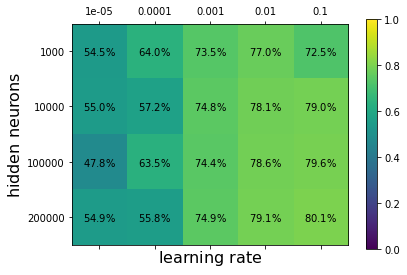

In [8]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# Training settings
parser = argparse.ArgumentParser(description='PyTorch SUSY Example')
parser.add_argument('--dataset_size', type=int, default=100000, metavar='DS',
                help='size of data set (default: 100000)')
parser.add_argument('--high_level_feats', type=bool, default=None, metavar='HLF',
                help='toggles high level features (default: None)')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.05, metavar='LR',
                help='learning rate (default: 0.02)')
parser.add_argument('--momentum', type=float, default=0.8, metavar='M',
                help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                help='disables CUDA training')
parser.add_argument('--seed', type=int, default=2, metavar='S',
                help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                help='how many batches to wait before logging training status')
args = parser.parse_args()

# set seed of random number generator
torch.manual_seed(args.seed)

grid_search(args)
